In [9]:
!pip install pandas numpy matplotlib scikit-learn keras

In [8]:
!pip install tensorflow

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [15]:
df = pd.read_csv('stock_data.csv')
df.head()

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


In [17]:
print(df.columns)

Index(['Date', 'AMZN', 'DPZ', 'BTC', 'NFLX'], dtype='object')


In [21]:
# Convert 'Date' column to datetime format and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Use 'AMZN' column for prediction
data = df[['AMZN']].values

# Normalize the data to range [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [22]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Set time step (number of previous days to look at)
time_step = 60

# Create input and output sequences
X, y = create_dataset(data_scaled, time_step)

# Reshape input to [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [23]:
# Split the dataset: 80% for training, 20% for testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
from keras import Input
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define input layer
input_layer = Input(shape=(X_train.shape[1], 1))

# Build the model
model = Sequential([
    input_layer,
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0144 - val_loss: 0.0560
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.2297e-04 - val_loss: 0.0016
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0527e-04 - val_loss: 0.0021
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9395e-04 - val_loss: 0.0023
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8657e-04 - val_loss: 0.0022
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8267e-04 - val_loss: 0.0025
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8080e-04 - val_loss: 0.0023
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7909e-04 - val_loss: 0.0027
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8126e-04 - val_loss: 0.0023
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7396e-04 - val_loss: 0.0019
Epoch 12/50
19/19 ━━━━━━━━━

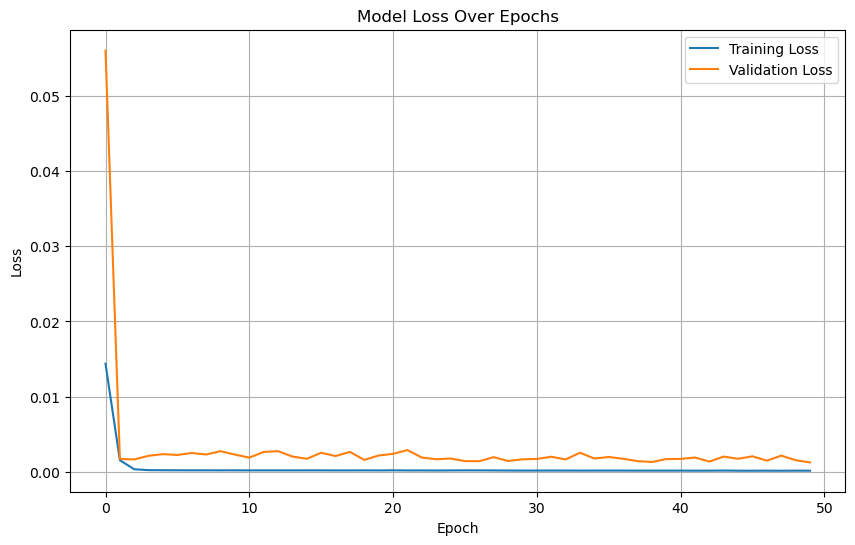

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Predict on training and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual price values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


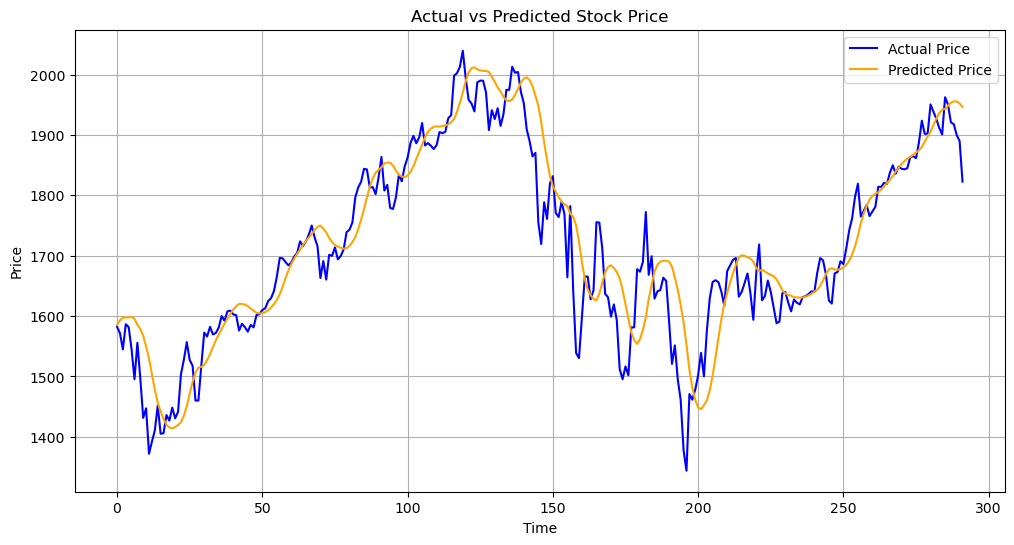

In [31]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate RMSE for training and testing predictions
rmse_train = np.sqrt(mean_squared_error(y_train_actual, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

Train RMSE: 20.32
Test RMSE: 62.88


In [36]:
from keras.saving import save_model
save_model(model, 'lstm_stock_model.keras')

In [37]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual Price': y_test_actual.flatten(),
    'Predicted Price': test_predict.flatten()
})

# Save to CSV
results_df.to_csv('amzn_predictions.csv', index=False)